In [1]:
# Importing the required libraries
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

In [2]:
# Reading the csv file and putting it into 'df' object.
df = pd.read_csv('heart_v2.csv')

In [3]:
df.columns

Index(['age', 'sex', 'BP', 'cholesterol', 'heart disease'], dtype='object')

In [4]:
df.head()

,age,sex,BP,cholesterol,heart disease
0,70,1,130,322,1
1,67,0,115,564,0
2,57,1,124,261,1
3,64,1,128,263,0
4,74,0,120,269,0


In [5]:
# Putting feature variable to X
X = df.drop('heart disease',axis=1)

# Putting response variable to y
y = df['heart disease']

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train.shape, X_test.shape

((189, 4), (81, 4))

## Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier

In [9]:
rf = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=3)

In [10]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=42)

In [11]:
rf.estimators_[0]

DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                       random_state=1608637542)

In [12]:
sample_tree = rf.estimators_[4]

In [13]:
# Importing required packages for visualization
from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

Creating helper functions to evaluate model performance and help plot the decision tree

In [14]:
def get_dt_graph(classifier):
    dot_data = StringIO()
    export_graphviz(decision_tree=classifier, 
                    out_file=dot_data, 
                    filled=True,
                    rounded=True,
                    feature_names=X.columns, 
                    class_names=['Disease', "No Disease"])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph

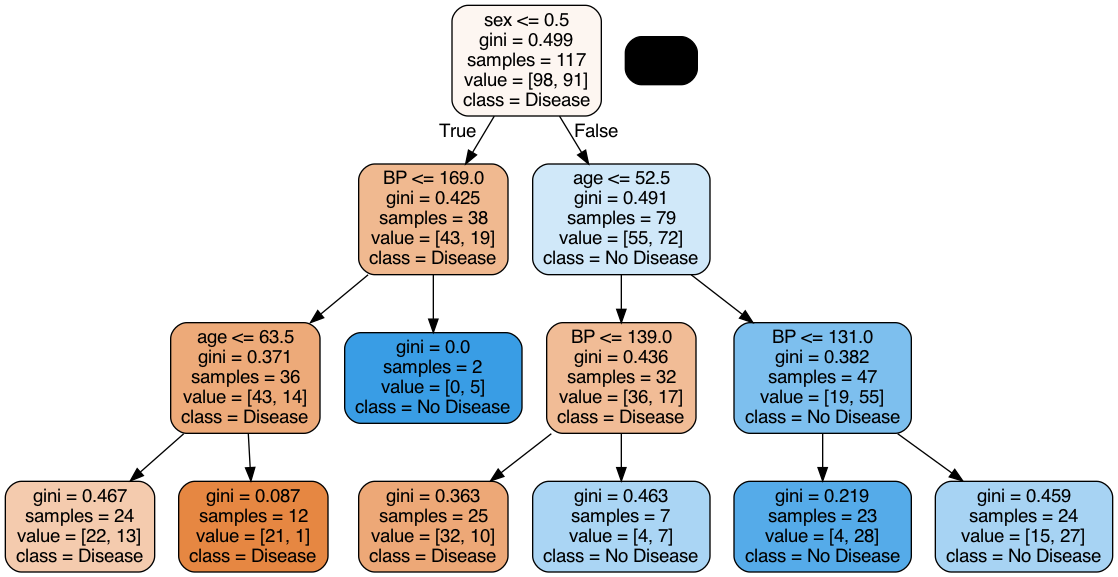

In [15]:
gph = get_dt_graph(sample_tree)
Image(gph.create_png(), width=700, height=700)

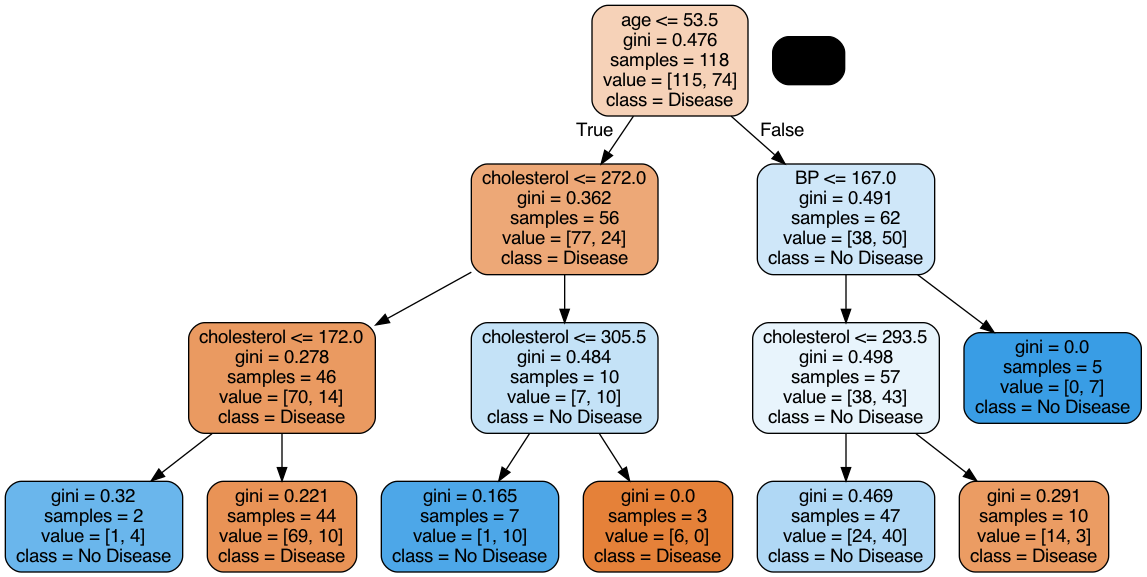

In [16]:
gph = get_dt_graph(rf.estimators_[2])
Image(gph.create_png(), width=700, height=700)

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [18]:
def evaluate_model(classifier):
    print("Train Accuracy :", accuracy_score(y_train, classifier.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, classifier.predict(X_train)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, classifier.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, classifier.predict(X_test)))

In [19]:
evaluate_model(rf)

Train Accuracy : 0.7407407407407407
Train Confusion Matrix:
[[80 21]
 [28 60]]
--------------------------------------------------
Test Accuracy : 0.6172839506172839
Test Confusion Matrix:
[[35 14]
 [17 15]]


#### Grid search for hyper-parameter tuning

In [20]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [1, 2, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'max_features': [2,3,4],
    'n_estimators': [10, 30, 50, 100, 200]
}

In [23]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [24]:
%%time
grid_search.fit(X,y)

Fitting 4 folds for each of 375 candidates, totalling 1500 fits
CPU times: user 517 ms, sys: 147 ms, total: 663 ms
Wall time: 17.9 s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 5, 10, 20],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'n_estimators': [10, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [25]:
rf_best = grid_search.best_estimator_

In [26]:
rf_best

RandomForestClassifier(max_depth=5, max_features=3, min_samples_leaf=5,
                       n_estimators=30, n_jobs=-1, random_state=42)

In [27]:
rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=3, min_samples_leaf=5,
                       n_estimators=30, n_jobs=-1, random_state=42)

In [28]:
evaluate_model(rf_best)

Train Accuracy : 0.7724867724867724
Train Confusion Matrix:
[[80 21]
 [22 66]]
--------------------------------------------------
Test Accuracy : 0.6666666666666666
Test Confusion Matrix:
[[35 14]
 [13 19]]


In [29]:
sample_tree = rf_best.estimators_[0]

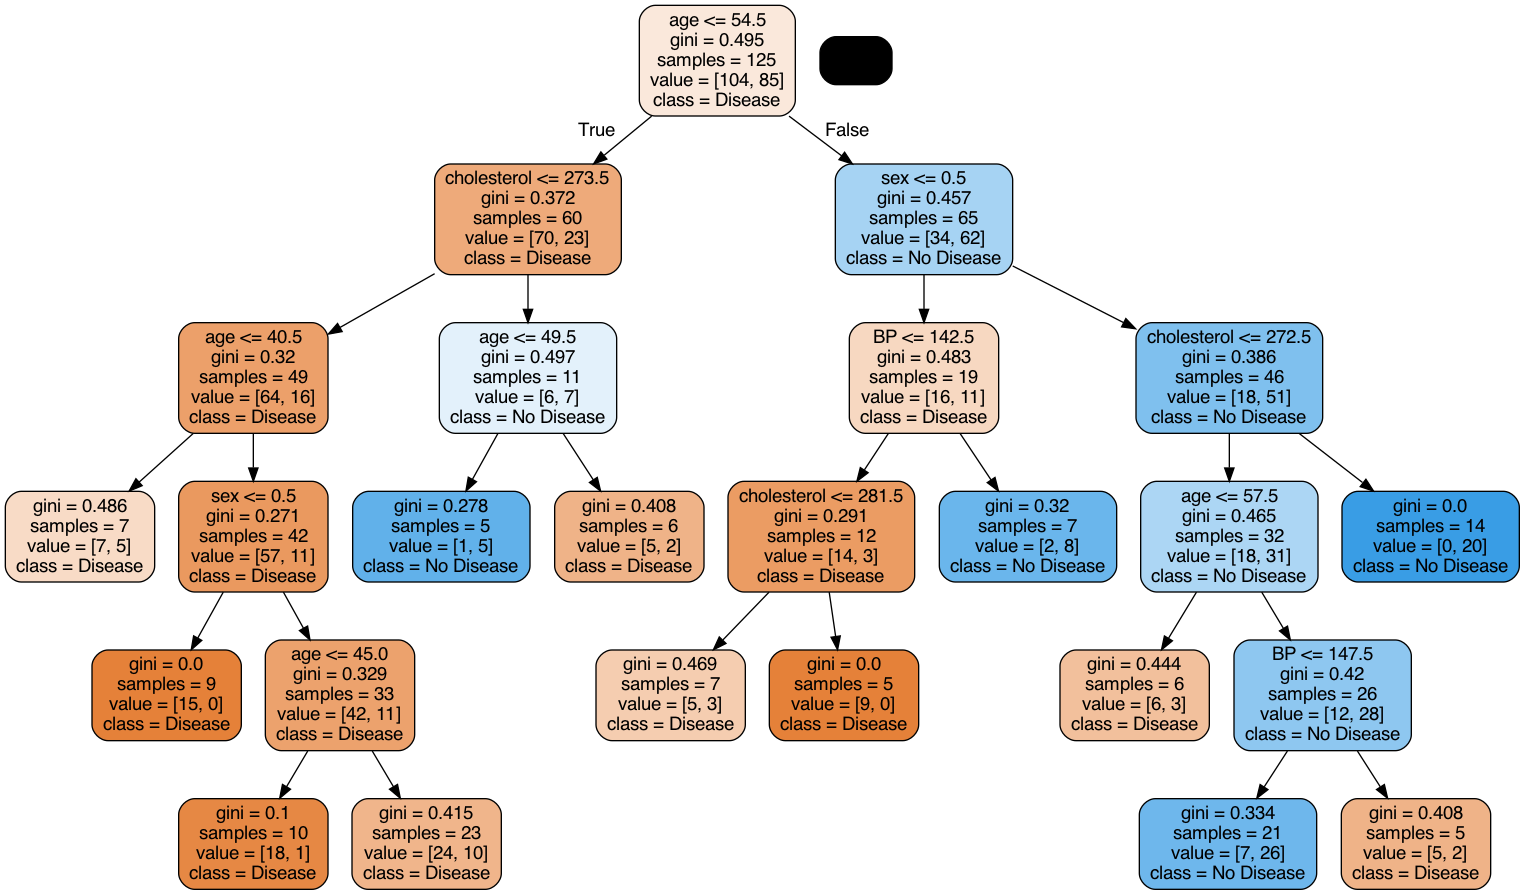

In [30]:
gph = get_dt_graph(sample_tree)
Image(gph.create_png())

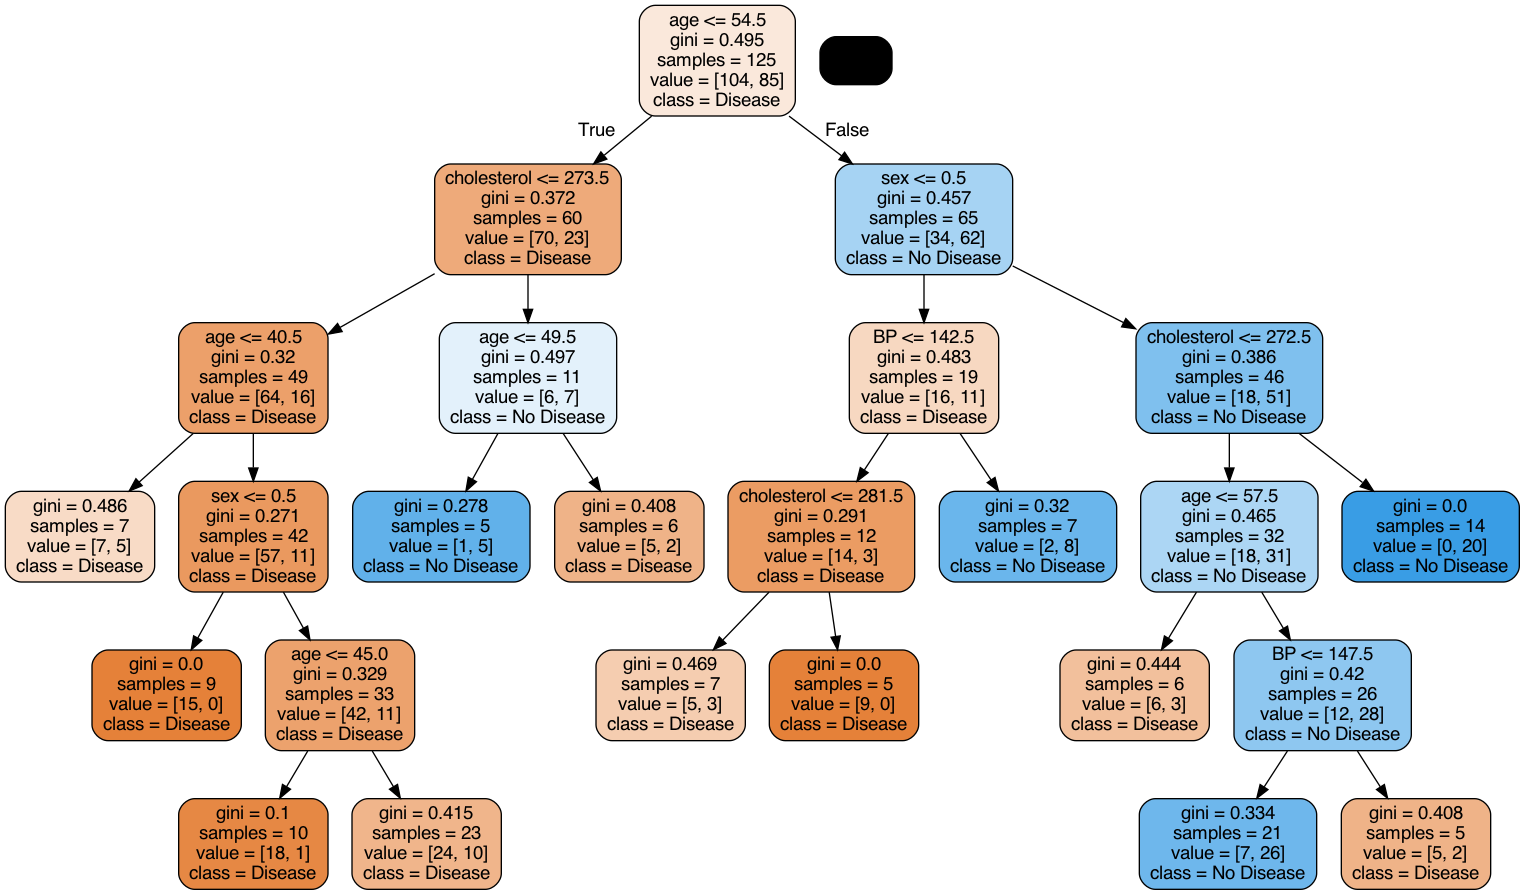

In [31]:
gph = get_dt_graph(rf_best.estimators_[0])
Image(gph.create_png(), height=600, width=600)

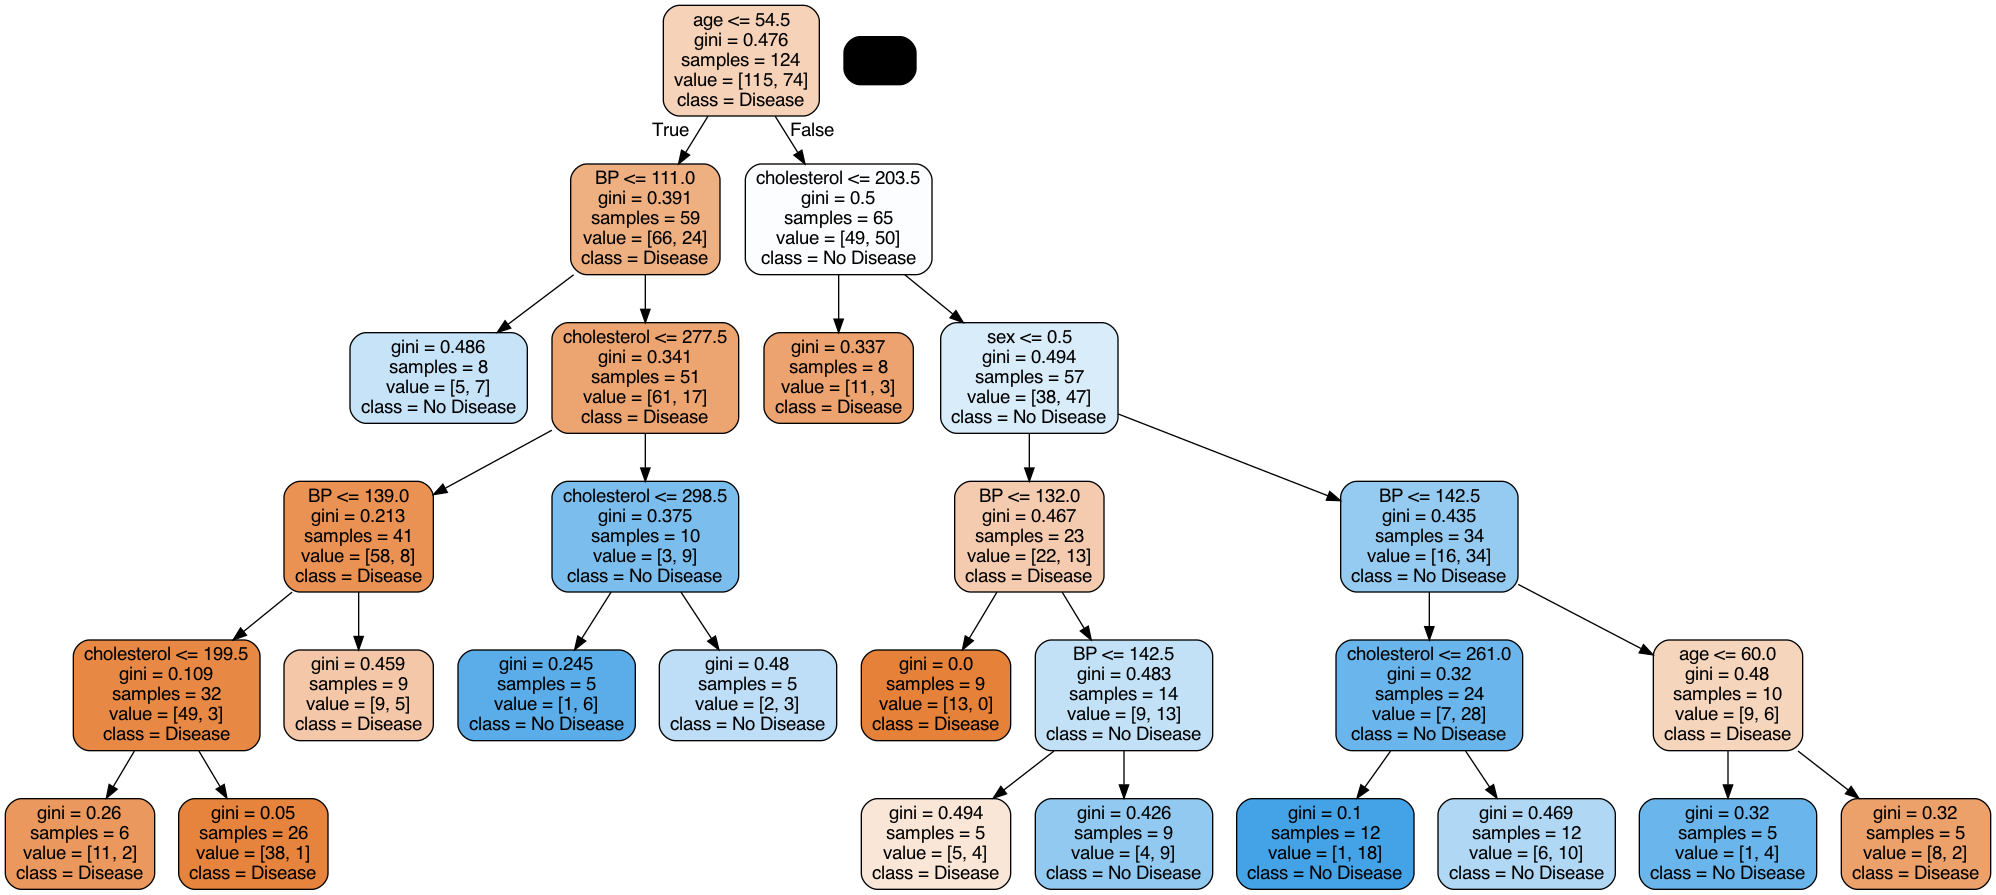

In [32]:
gph = get_dt_graph(rf_best.estimators_[10])
Image(gph.create_png(), height=600, width=600)

### Variable importance in RandomForest and Decision trees

In [33]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5, n_estimators=100, oob_score=True)

In [34]:
classifier_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=42)

In [35]:
classifier_rf.feature_importances_

array([0.37539743, 0.13780788, 0.20834585, 0.27844883])

In [36]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": classifier_rf.feature_importances_
})

In [37]:
imp_df.sort_values(by="Imp", ascending=False)

,Varname,Imp
0,age,0.375397
3,cholesterol,0.278449
2,BP,0.208346
1,sex,0.137808
